学习参考：https://blog.csdn.net/weixin_54202028/article/details/126299959

## 安装工具包

In [1]:
!pip install numpy pandas matplotlib tqdm opencv-python pillow onnx onnxruntime -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
     |████████████████████████████████| 13.5 MB 60.8 MB/s eta 0:00:01
     |████████████████████████████████| 4.5 MB 43.8 MB/s eta 0:00:01
     |████████████████████████████████| 1.0 MB 41.2 MB/s eta 0:00:01
     |████████████████████████████████| 6.4 MB 32.9 MB/s eta 0:00:01
     |████████████████████████████████| 15.7 MB 57.8 MB/s eta 0:00:01
     |████████████████████████████████| 46 kB 41.9 MB/s eta 0:00:01
     |████████████████████████████████| 86 kB 49.5 MB/s eta 0:00:01
     |████████████████████████████████| 532 kB 35.8 MB/s eta 0:00:01
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.1
    Uninstalling protobuf-3.19.1:
      Successfully uninstalled protobuf-3.19.1
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.4
    Uninstalling numpy-1.21.4:
      Successfully uninstalled numpy-1.21.4


## 安装pytorch

In [2]:
!pip3 install torch torchvision --extra-index-url https://download.pytorch.org/whl/cu113

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple, https://download.pytorch.org/whl/cu113


## 导出ONNX模型

In [3]:
import torch
from torchvision import models

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('device', device)

device cuda:0


In [10]:
import torch.nn as nn
import torchvision.transforms as transforms
from PIL import Image

from torch.utils.data import ConcatDataset, DataLoader, Subset, Dataset
from torchvision.datasets import DatasetFolder, VisionDataset
from torchvision import models
import torch.optim as optim
import torch
import torchvision
import torch.nn.functional as F

import numpy as np
import pandas as pd

import shutil
import os

import matplotlib.pyplot as plt
%matplotlib inline

# 忽略烦人的红色提示
import warnings
warnings.filterwarnings("ignore")

# 随机数和python函数库
import random
import math

# 进度条
from tqdm import tqdm

# cv库
import cv2 as cv

# 有 GPU 就用 GPU，没有就用 CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [11]:
from torch import nn
class Classify(nn.Module):
    def __init__(self):
        super(Classify, self).__init__()
        
        # Input图片是3*256*256
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, 1, 1), # 64*256*256
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0) # 64*128*128
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, 1, 1), # 128*128*128
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0) # 128*64*64
        )

        self.layer3 = nn.Sequential(
            nn.Conv2d(128, 256, 3, 1, 1), # 256*64*64
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0) #256*32*32
        )

        self.layer4 = nn.Sequential(
            nn.Conv2d(256, 512, 3, 1, 1), # 512*32*32
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2, 0) # 512*16*16
        )
       
        # 定义全连接部分
        self.fc1 = nn.Sequential(
            nn.Linear(512*16*16,512),
            nn.ReLU()
        )

        self.fc2 = nn.Sequential(
            nn.Linear(512, 256),
            nn.ReLU()
        )

        self.fc3 = nn.Sequential(
            nn.Linear(256, 11)
        )
        

    def forward(self, x):

        x1 = self.layer1(x)        
        x2 = self.layer2(x1)    
        x3 = self.layer3(x2)     
        x4 = self.layer4(x3)
   
        xf1 = x4.flatten(1)
        #xf1 = xf1.view(xf1.size()[0],-1)
        xf2 = self.fc1(xf1)
        xf3 = self.fc2(xf2)

        result = self.fc3(xf3)
               
        return result

In [12]:
model = torch.load('checkpoints/dog25_pytorch_20230122.pth')
model = model.eval().to(device)

## 测试中文字体

In [13]:
# Linux操作系统，例如 云GPU平台：https://featurize.cn/?s=d7ce99f842414bfcaea5662a97581bd1
# 如果遇到 SSL 相关报错，重新运行本代码块即可
!wget https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf -O /environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf
!rm -rf /home/featurize/.cache/matplotlib

import matplotlib
matplotlib.rc("font",family='SimHei') # 中文字体

--2023-01-29 19:19:30--  https://zihao-openmmlab.obs.cn-east-3.myhuaweicloud.com/20220716-mmclassification/dataset/SimHei.ttf
正在连接 172.16.0.13:5848... 已连接。
已发出 Proxy 请求，正在等待回应... 200 OK
长度： 10050868 (9.6M) [application/x-font-ttf]
正在保存至: “/environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf”

/environment/minico 100%[===================>]   9.58M  12.9MB/s    用时 0.7s    

2023-01-29 19:19:31 (12.9 MB/s) - 已保存 “/environment/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/fonts/ttf/SimHei.ttf” [10050868/10050868])



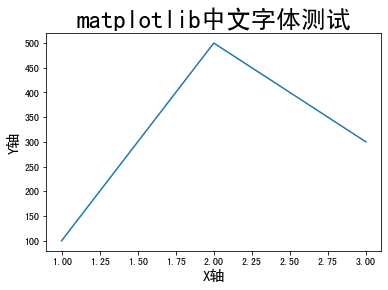

In [14]:
plt.plot([1,2,3], [100,500,300])
plt.title('matplotlib中文字体测试', fontsize=25)
plt.xlabel('X轴', fontsize=15)
plt.ylabel('Y轴', fontsize=15)
plt.show()

## 随机一个输入跑通模型

In [16]:
x = torch.randn(1, 3, 256, 256).to(device)

In [17]:
output = model(x)

In [18]:
output.shape

torch.Size([1, 25])

## pytorch模型转ONNX

In [23]:
x = torch.randn(1, 3, 256, 256).to(device)

with torch.no_grad():
    torch.onnx.export(
        model,                   # 要转换的模型
        x,                       # 模型的任意一组输入
        'dog25_model.onnx', # 导出的 ONNX 文件名
        opset_version=11,        # ONNX 算子集版本
        input_names=['input'],   # 输入 Tensor 的名称（自己起名字）
        output_names=['output']  # 输出 Tensor 的名称（自己起名字）
    ) 

## 验证ONNX模型导出成功

In [25]:
import onnx

# 读取 ONNX 模型
onnx_model = onnx.load('dog25_model.onnx')

# 检查模型格式是否正确
onnx.checker.check_model(onnx_model)

print('无报错，onnx模型载入成功')

无报错，onnx模型载入成功


## 以可读的形式打印计算图

In [21]:
print(onnx.helper.printable_graph(onnx_model.graph))

graph torch-jit-export (
  %input[FLOAT, 1x3x256x256]
) initializers (
  %fc1.0.weight[FLOAT, 512x131072]
  %fc1.0.bias[FLOAT, 512]
  %fc2.0.weight[FLOAT, 256x512]
  %fc2.0.bias[FLOAT, 256]
  %fc3.weight[FLOAT, 25x256]
  %fc3.bias[FLOAT, 25]
  %58[FLOAT, 64x3x3x3]
  %59[FLOAT, 64]
  %61[FLOAT, 128x64x3x3]
  %62[FLOAT, 128]
  %64[FLOAT, 256x128x3x3]
  %65[FLOAT, 256]
  %67[FLOAT, 512x256x3x3]
  %68[FLOAT, 512]
) {
  %57 = Conv[dilations = [1, 1], group = 1, kernel_shape = [3, 3], pads = [1, 1, 1, 1], strides = [1, 1]](%input, %58, %59)
  %37 = Relu(%57)
  %38 = MaxPool[ceil_mode = 0, kernel_shape = [2, 2], pads = [0, 0, 0, 0], strides = [2, 2]](%37)
  %60 = Conv[dilations = [1, 1], group = 1, kernel_shape = [3, 3], pads = [1, 1, 1, 1], strides = [1, 1]](%38, %61, %62)
  %41 = Relu(%60)
  %42 = MaxPool[ceil_mode = 0, kernel_shape = [2, 2], pads = [0, 0, 0, 0], strides = [2, 2]](%41)
  %63 = Conv[dilations = [1, 1], group = 1, kernel_shape = [3, 3], pads = [1, 1, 1, 1], strides = [1, 1]](

## 使用Netron对onnx模型可视化

### https://netron.app

使用方法，打开网址然后将之前导出的ONNX文件导入进去可以看到可视化的模型结构，以及模型内部的信息。

## 推理引擎ONNX Runtime部署-预测单张图像
使用推理引擎 ONNX Runtime，读取 onnx 格式的模型文件，对单张图像文件进行预测。

### 应用场景
以下代码在需要部署的硬件上运行

只需把onnx模型文件发到部署硬件上，并安装 ONNX Runtime 环境，用几行代码就可以运行模型了。

In [26]:
import onnxruntime
import numpy as np
import torch

### 载入 onnx 模型，获取 ONNX Runtime 推理器

In [27]:
ort_session = onnxruntime.InferenceSession('dog25_model.onnx')

### 构造输入，获取输出结果

In [28]:
x = torch.randn(1, 3, 256, 256).numpy()

In [29]:
x.shape

(1, 3, 256, 256)

In [30]:
# onnx runtime 输入
ort_inputs = {'input': x}

# onnx runtime 输出
ort_output = ort_session.run(['output'], ort_inputs)[0]

注意，输入输出张量的名称需要和 torch.onnx.export 中设置的输入输出名对应

In [31]:
ort_output.shape

(1, 25)

## 预处理

In [32]:
from torchvision import transforms

# 测试集图像预处理-RCTN：缩放、裁剪、转 Tensor、归一化
test_transform = transforms.Compose([transforms.Resize(300),
                                     transforms.CenterCrop(256),
                                     transforms.ToTensor(),
                                     transforms.Normalize(
                                         mean=[0.485, 0.456, 0.406], 
                                         std=[0.229, 0.224, 0.225])
                                    ])

### 载入测试图像

In [33]:
img_path = './dataset/test/萨摩耶1.jpg'

In [34]:
# 用 pillow 载入
from PIL import Image
img_pil = Image.open(img_path)

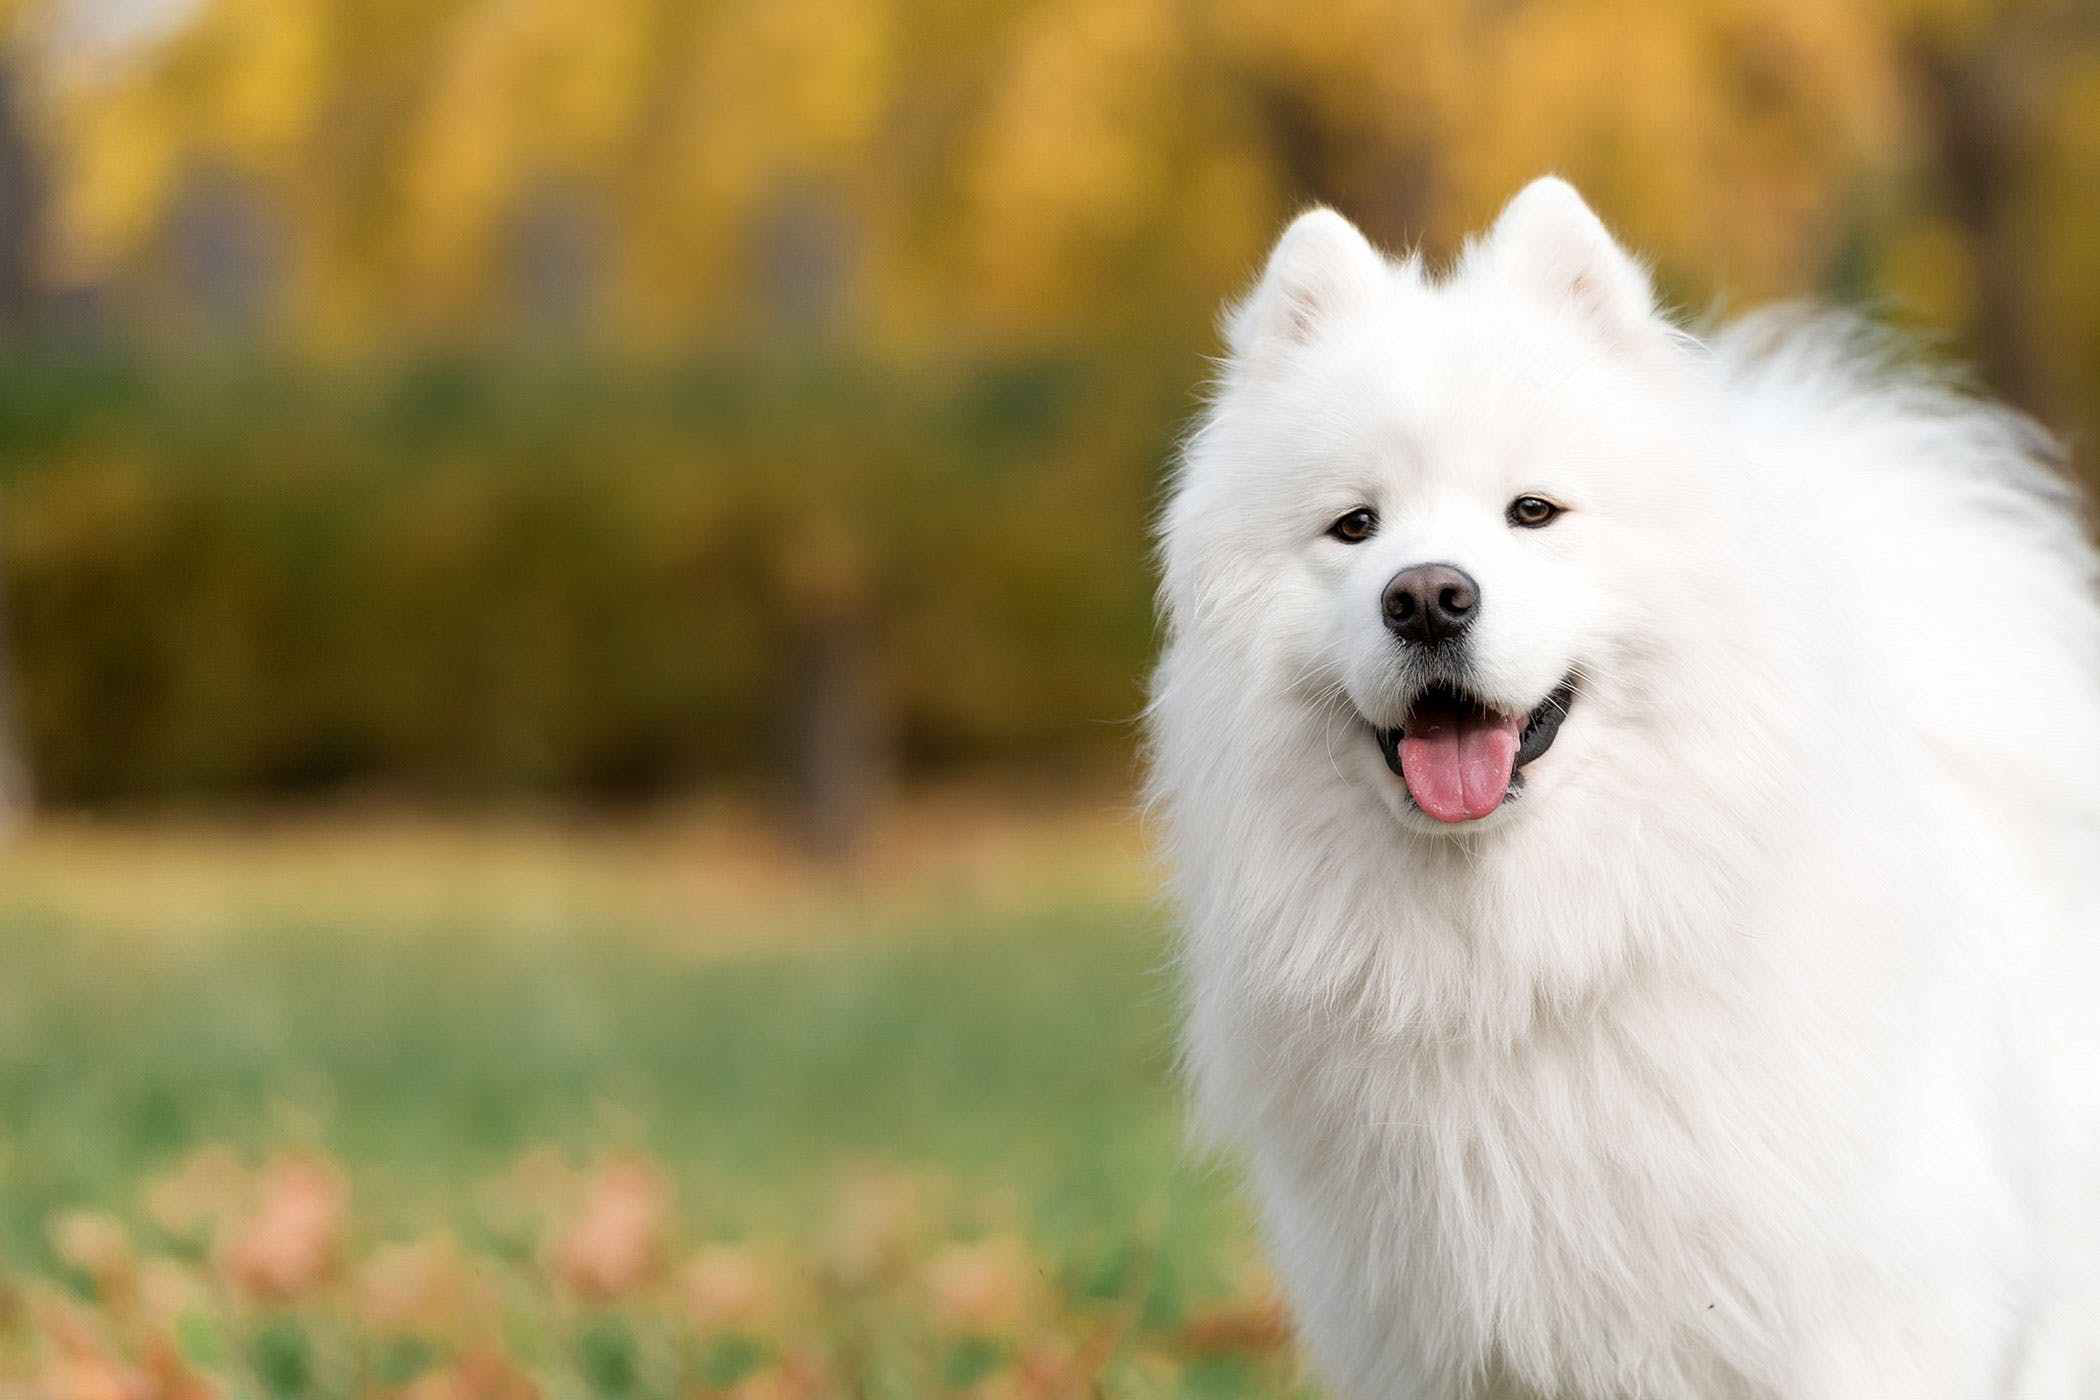

In [35]:
img_pil

### 运行预处理

In [36]:
input_img = test_transform(img_pil)
input_img.shape

torch.Size([3, 256, 256])

In [37]:
input_tensor = input_img.unsqueeze(0).numpy()
input_tensor.shape

(1, 3, 256, 256)

### ONNX Runtime预测

In [39]:
# ONNX Runtime 输入
ort_inputs = {'input': input_tensor}

In [40]:
# ONNX Runtime 输出
pred_logits = ort_session.run(['output'], ort_inputs)[0]
pred_logits = torch.tensor(pred_logits)

In [41]:
pred_logits.shape

torch.Size([1, 25])

In [42]:
import torch.nn.functional as F
pred_softmax = F.softmax(pred_logits, dim=1) # 对 logit 分数做 softmax 运算

In [43]:
pred_softmax.shape

torch.Size([1, 25])

### 解析预测结果

载入类别和对应 ID

In [44]:
idx_to_labels = np.load('idx_to_labels.npy', allow_pickle=True).item()

In [45]:
idx_to_labels

{0: '兰伯格犬',
 1: '博美犬',
 2: '吉娃娃',
 3: '哈威那犬',
 4: '哈巴狗',
 5: '圣伯纳犬',
 6: '大白熊犬',
 7: '巴吉度猎犬',
 8: '德国短毛指示犬',
 9: '拳师犬',
 10: '斯塔福斗牛梗犬',
 11: '日本狐狸犬',
 12: '柴犬',
 13: '比格犬',
 14: '爱尔兰软毛犬',
 15: '约克夏犬',
 16: '纽芬兰犬',
 17: '美洲斗牛犬',
 18: '美洲比特犬',
 19: '苏格兰猎犬',
 20: '英国可卡犬',
 21: '英国蹲猎犬',
 22: '荷兰毛狮犬',
 23: '萨摩耶',
 24: '迷你杜宾犬'}

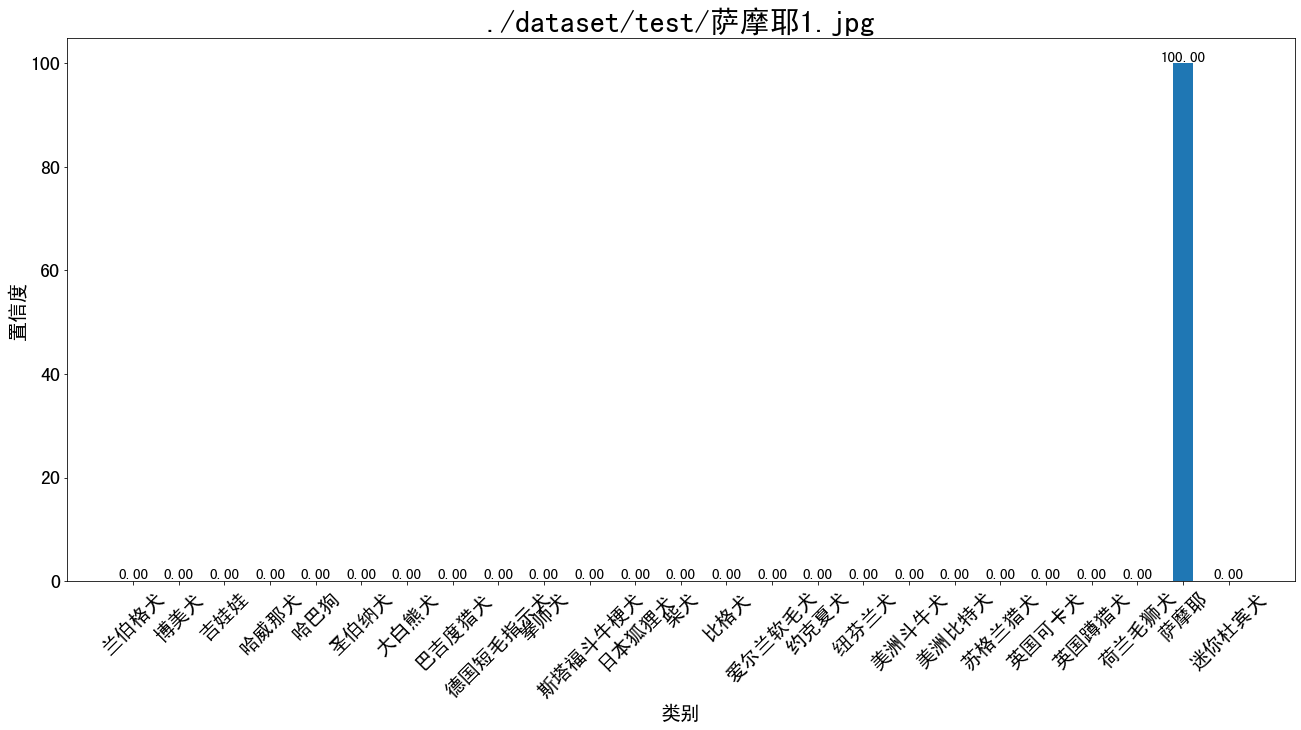

In [46]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(22, 10))

x = idx_to_labels.values()
y = pred_softmax.cpu().detach().numpy()[0] * 100
width = 0.45 # 柱状图宽度

ax = plt.bar(x, y, width)

plt.bar_label(ax, fmt='%.2f', fontsize=15) # 置信度数值
plt.tick_params(labelsize=20) # 设置坐标文字大小

plt.title(img_path, fontsize=30)
plt.xticks(rotation=45) # 横轴文字旋转
plt.xlabel('类别', fontsize=20)
plt.ylabel('置信度', fontsize=20)
plt.show()